<a href="https://colab.research.google.com/github/luiseduardoballarati/MSc-CS-Dissertation/blob/main/Network_Generator_Testing%26Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
from collections import defaultdict
import re
from datetime import datetime
#import spacy
import plotly.express as px
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Dataset info

In [1]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bath/Dissertation/The Guardian Datasets/business_guardian_articles.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25539 entries, 0 to 25538
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type                25539 non-null  object
 1   sectionId           25539 non-null  object
 2   sectionName         25539 non-null  object
 3   webPublicationDate  25539 non-null  object
 4   webTitle            25539 non-null  object
 5   webUrl              25539 non-null  object
 6   content             25518 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


In [ ]:
df = df.sample(n=1000, random_state=42)

In [ ]:
df.head()

,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,content
2166,article,world,World news,2021-09-30T15:45:52Z,Demand for private jets soars as rich travelle...,https://www.theguardian.com/world/2021/sep/30/...,Private jet providers are experiencing “unprec...
16560,article,business,Business,2019-07-04T20:51:39Z,George Osborne must understand the IMF role is...,https://www.theguardian.com/business/nils-prat...,If George Osborne’s “friends” were not adverti...
5570,article,world,World news,2021-03-15T11:26:00Z,Cheese sales soar in French lockdown – but an ...,https://www.theguardian.com/world/2021/mar/15/...,How did the French keep smiling through the Co...
4219,article,uk-news,UK news,2021-05-28T14:12:56Z,Bank holiday traffic: sun and Covid easing may...,https://www.theguardian.com/uk-news/2021/may/2...,"Sunny weather, the easing of Covid restriction..."
11286,article,business,Business,2020-05-04T23:01:20Z,Food deliveries to vulnerable in UK 'need bett...,https://www.theguardian.com/business/2020/may/...,Consumer and disability rights groups have cal...


In [ ]:
df.drop(['webUrl'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2166 to 10855
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type                1000 non-null   object
 1   sectionId           1000 non-null   object
 2   sectionName         1000 non-null   object
 3   webPublicationDate  1000 non-null   object
 4   webTitle            1000 non-null   object
 5   content             1000 non-null   object
dtypes: object(6)
memory usage: 87.0+ KB


In [ ]:
df.iloc[0].content

'Private jet providers are experiencing “unprecedented demand” from wealthy customers seeking to avoid the “mosh pit” of commercial flights on autumn getaways as coronavirus travel restrictions ease. Flexjet and PrivateFly, which supply private jets to rich families and business executives, said they were “experiencing exceptionally strong demand” for September and October travel at a time of year when bookings normally fall away. Flexjet, which offers shared ownership in its fleet of private jets in Europe, said it operated 53% more flights in September than the previous month, bucking the usual seasonal trends. Marine Eugène, the European managing director of Flexjet and PrivateFly, said: “Our industry in Europe traditionally sees a significant peak in July and August, followed by a tailing off in September – but not this year. “We are currently experiencing exceptionally strong demand, with the appetite for personal travel not yet sated after a later start to summer due to restricti

In [ ]:
  df.iloc[0].webTitle

'Demand for private jets soars as rich travellers try to avoid ‘mosh pit’'

# NLTK functions

In [ ]:
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a regex pattern for non-words (only keeping words with letters)
pattern = re.compile(r'^[a-zA-Z]+$')

In [ ]:
def process(content):
  # Sentence tokenization
  sentences = sent_tokenize(content)
  # Process each sentence
  processed_sentences = [process_sentence(sentence) for sentence in sentences]
  return processed_sentences

In [ ]:
# Function to process each sentence
def process_sentence(sentence):
    # Word tokenization
    words = word_tokenize(sentence)
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words and pattern.match(word)]
    #filtered_words = [word for word in words]
    # POS tagging
    pos_tags = pos_tag(filtered_words)
    return pos_tags

In [ ]:
import time

# Start the timer
start_time = time.time()

# Your processing code
df['Processed Sentences'] = df['content'].apply(lambda x: process(x) if isinstance(x, str) else None)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to process the sentences: {elapsed_time} seconds")

Time taken to process the sentences: 47.02213430404663 seconds


In [ ]:
df.iloc[0]['content']

'Private jet providers are experiencing “unprecedented demand” from wealthy customers seeking to avoid the “mosh pit” of commercial flights on autumn getaways as coronavirus travel restrictions ease. Flexjet and PrivateFly, which supply private jets to rich families and business executives, said they were “experiencing exceptionally strong demand” for September and October travel at a time of year when bookings normally fall away. Flexjet, which offers shared ownership in its fleet of private jets in Europe, said it operated 53% more flights in September than the previous month, bucking the usual seasonal trends. Marine Eugène, the European managing director of Flexjet and PrivateFly, said: “Our industry in Europe traditionally sees a significant peak in July and August, followed by a tailing off in September – but not this year. “We are currently experiencing exceptionally strong demand, with the appetite for personal travel not yet sated after a later start to summer due to restricti

In [ ]:
sentence = df.iloc[0]['content'][0:198]

In [ ]:
sentence2 = df.iloc[0]['content'][199:433]

In [ ]:
print(df.iloc[0]['Processed Sentences'][0])

[('Private', 'JJ'), ('jet', 'NN'), ('providers', 'NNS'), ('experiencing', 'VBG'), ('unprecedented', 'JJ'), ('demand', 'NN'), ('wealthy', 'NN'), ('customers', 'NNS'), ('seeking', 'VBG'), ('avoid', 'JJ'), ('mosh', 'NN'), ('pit', 'JJ'), ('commercial', 'JJ'), ('flights', 'NNS'), ('autumn', 'VBP'), ('getaways', 'NNS'), ('coronavirus', 'VBP'), ('travel', 'NN'), ('restrictions', 'NNS'), ('ease', 'VBP')]


# Spacy functions

In [ ]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Process the sentence with SpaCy
doc = nlp(sentence)

# Print dependency parsing results
for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}, Dependency: {token.dep_}, Head: {token.head.text}")

# Identify direct and indirect objects
for token in doc:
    if token.dep_ == "dobj":  # Direct Object
        print(f"Direct Object: {token.text}")
    if token.dep_ == "iobj":  # Indirect Object
        print(f"Indirect Object: {token.text}")

Token: Private, POS: ADJ, Dependency: amod, Head: providers
Token: jet, POS: NOUN, Dependency: compound, Head: providers
Token: providers, POS: NOUN, Dependency: nsubj, Head: experiencing
Token: are, POS: AUX, Dependency: aux, Head: experiencing
Token: experiencing, POS: VERB, Dependency: ROOT, Head: experiencing
Token: “, POS: PUNCT, Dependency: punct, Head: demand
Token: unprecedented, POS: ADJ, Dependency: amod, Head: demand
Token: demand, POS: NOUN, Dependency: dobj, Head: experiencing
Token: ”, POS: PUNCT, Dependency: punct, Head: demand
Token: from, POS: ADP, Dependency: prep, Head: demand
Token: wealthy, POS: ADJ, Dependency: amod, Head: customers
Token: customers, POS: NOUN, Dependency: pobj, Head: from
Token: seeking, POS: VERB, Dependency: acl, Head: customers
Token: to, POS: PART, Dependency: aux, Head: avoid
Token: avoid, POS: VERB, Dependency: xcomp, Head: seeking
Token: the, POS: DET, Dependency: det, Head: pit
Token: “, POS: PUNCT, Dependency: punct, Head: pit
Token: mos

In [ ]:
doc = nlp(sentence)
lista = []
# Print dependency parsing results
for token in doc:
    lista.append(token.pos_)
lista

['ADJ',
 'NOUN',
 'NOUN',
 'AUX',
 'VERB',
 'PUNCT',
 'ADJ',
 'NOUN',
 'PUNCT',
 'ADP',
 'ADJ',
 'NOUN',
 'VERB',
 'PART',
 'VERB',
 'DET',
 'PUNCT',
 'PROPN',
 'NOUN',
 'PUNCT',
 'ADP',
 'ADJ',
 'NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 'NOUN',
 'NOUN',
 'PUNCT']

In [ ]:
sentence

'Private jet providers are experiencing “unprecedented demand” from wealthy customers seeking to avoid the “mosh pit” of commercial flights on autumn getaways as coronavirus travel restrictions ease.'

In [ ]:
process_sentence(sentence)

[('Private', 'JJ'),
 ('jet', 'NN'),
 ('providers', 'NNS'),
 ('experiencing', 'VBG'),
 ('unprecedented', 'JJ'),
 ('demand', 'NN'),
 ('wealthy', 'NN'),
 ('customers', 'NNS'),
 ('seeking', 'VBG'),
 ('avoid', 'JJ'),
 ('mosh', 'NN'),
 ('pit', 'JJ'),
 ('commercial', 'JJ'),
 ('flights', 'NNS'),
 ('autumn', 'VBP'),
 ('getaways', 'NNS'),
 ('coronavirus', 'VBP'),
 ('travel', 'NN'),
 ('restrictions', 'NNS'),
 ('ease', 'VBP')]

In [ ]:
text = 'Private jet providers experiencing unprecedent demand wealthy customers seeking avoid mosh pit commercial flights autumn getaways coronavirus travel restrictions ease'

In [ ]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Process the sentence with SpaCy
doc = nlp(text)

# Print dependency parsing results
for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}, Dependency: {token.dep_}, Head: {token.head.text}")

# Identify direct and indirect objects
for token in doc:
    if token.dep_ == "dobj":  # Direct Object
        print(f"Direct Object: {token.text}")
    if token.dep_ == "iobj":  # Indirect Object
        print(f"Indirect Object: {token.text}")

Token: Private, POS: ADJ, Dependency: amod, Head: providers
Token: jet, POS: NOUN, Dependency: compound, Head: providers
Token: providers, POS: NOUN, Dependency: nsubj, Head: getaways
Token: experiencing, POS: VERB, Dependency: acl, Head: providers
Token: unprecedent, POS: ADJ, Dependency: amod, Head: demand
Token: demand, POS: NOUN, Dependency: nmod, Head: customers
Token: wealthy, POS: ADJ, Dependency: amod, Head: customers
Token: customers, POS: NOUN, Dependency: dobj, Head: experiencing
Token: seeking, POS: VERB, Dependency: advcl, Head: experiencing
Token: avoid, POS: VERB, Dependency: xcomp, Head: seeking
Token: mosh, POS: NOUN, Dependency: compound, Head: pit
Token: pit, POS: NOUN, Dependency: nmod, Head: flights
Token: commercial, POS: ADJ, Dependency: amod, Head: flights
Token: flights, POS: NOUN, Dependency: compound, Head: autumn
Token: autumn, POS: NOUN, Dependency: nsubj, Head: getaways
Token: getaways, POS: VERB, Dependency: ROOT, Head: getaways
Token: coronavirus, POS: N

In [ ]:
# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define the sentence
sentence = "Private jet providers are experiencing “unprecedented demand” from wealthy customers seeking to avoid the “mosh pit” of commercial flights on autumn getaways as coronavirus travel restrictions ease."

# Process the sentence with spaCy
doc = nlp(sentence)

lista = []
# Print the dependencies
for token in doc:
    lista.extend([(token.text, token.dep_, token.head.text)])
lista

[('Private', 'amod', 'providers'),
 ('jet', 'compound', 'providers'),
 ('providers', 'nsubj', 'experiencing'),
 ('are', 'aux', 'experiencing'),
 ('experiencing', 'ROOT', 'experiencing'),
 ('“', 'punct', 'demand'),
 ('unprecedented', 'amod', 'demand'),
 ('demand', 'dobj', 'experiencing'),
 ('”', 'punct', 'demand'),
 ('from', 'prep', 'demand'),
 ('wealthy', 'amod', 'customers'),
 ('customers', 'pobj', 'from'),
 ('seeking', 'acl', 'customers'),
 ('to', 'aux', 'avoid'),
 ('avoid', 'xcomp', 'seeking'),
 ('the', 'det', 'pit'),
 ('“', 'punct', 'pit'),
 ('mosh', 'compound', 'pit'),
 ('pit', 'dobj', 'avoid'),
 ('”', 'punct', 'pit'),
 ('of', 'prep', 'pit'),
 ('commercial', 'amod', 'flights'),
 ('flights', 'pobj', 'of'),
 ('on', 'prep', 'flights'),
 ('autumn', 'compound', 'getaways'),
 ('getaways', 'pobj', 'on'),
 ('as', 'prep', 'pit'),
 ('coronavirus', 'compound', 'travel'),
 ('travel', 'compound', 'restrictions'),
 ('restrictions', 'compound', 'ease'),
 ('ease', 'pobj', 'as'),
 ('.', 'punct', '

In [ ]:
# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define the sentence
sentence2

# Process the sentence with spaCy
doc = nlp(sentence2)

lista2 = []
# Print the dependencies
for token in doc:
    lista2.extend([(token.text, token.dep_, token.head.text)])

# Graphs

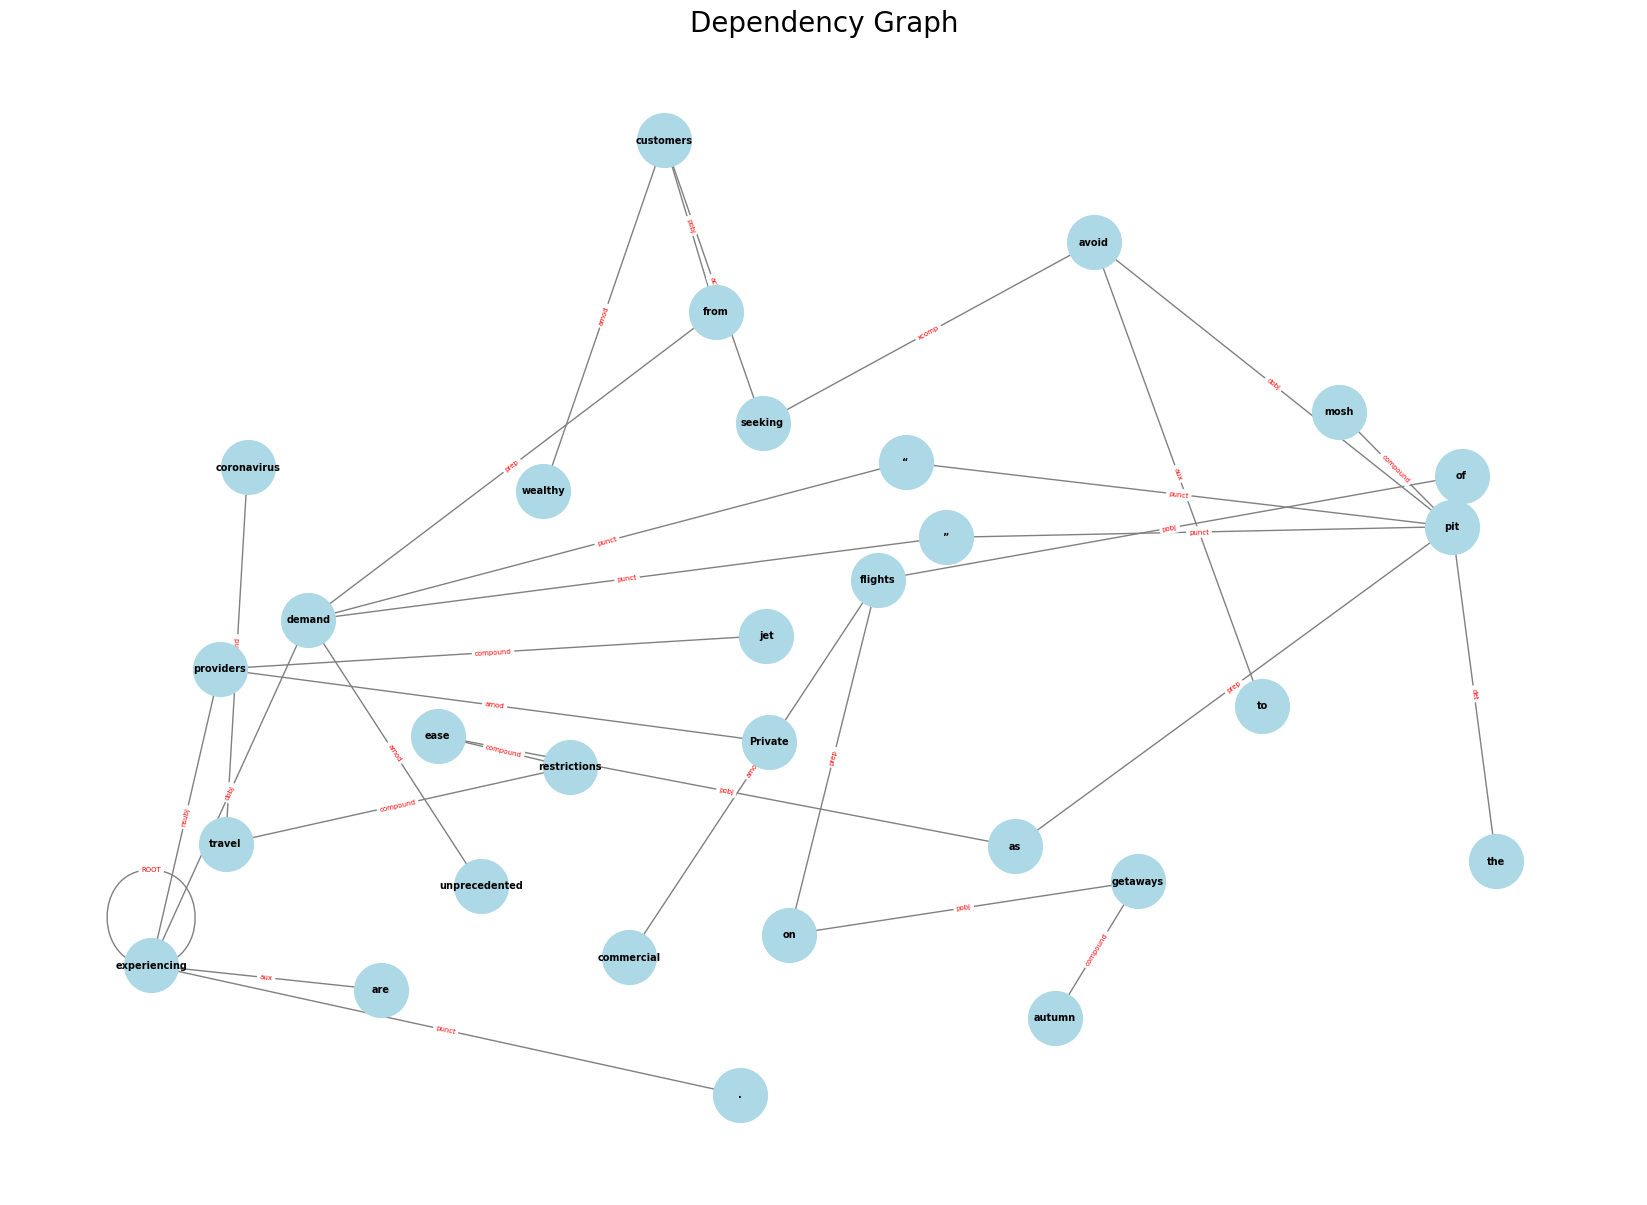

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# The provided data
data = [
    ('Private', 'amod', 'providers'),
    ('jet', 'compound', 'providers'),
    ('providers', 'nsubj', 'experiencing'),
    ('are', 'aux', 'experiencing'),
    ('experiencing', 'ROOT', 'experiencing'),
    ('“', 'punct', 'demand'),
    ('unprecedented', 'amod', 'demand'),
    ('demand', 'dobj', 'experiencing'),
    ('”', 'punct', 'demand'),
    ('from', 'prep', 'demand'),
    ('wealthy', 'amod', 'customers'),
    ('customers', 'pobj', 'from'),
    ('seeking', 'acl', 'customers'),
    ('to', 'aux', 'avoid'),
    ('avoid', 'xcomp', 'seeking'),
    ('the', 'det', 'pit'),
    ('“', 'punct', 'pit'),
    ('mosh', 'compound', 'pit'),
    ('pit', 'dobj', 'avoid'),
    ('”', 'punct', 'pit'),
    ('of', 'prep', 'pit'),
    ('commercial', 'amod', 'flights'),
    ('flights', 'pobj', 'of'),
    ('on', 'prep', 'flights'),
    ('autumn', 'compound', 'getaways'),
    ('getaways', 'pobj', 'on'),
    ('as', 'prep', 'pit'),
    ('coronavirus', 'compound', 'travel'),
    ('travel', 'compound', 'restrictions'),
    ('restrictions', 'compound', 'ease'),
    ('ease', 'pobj', 'as'),
    ('.', 'punct', 'experiencing')
]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for source, dep, target in data:
    G.add_edge(source, target, label=dep)

pos = nx.spring_layout(G, k=0.7)  # Increase k value to spread out nodes more

# Set up the plot
plt.figure(figsize=(21, 15))  # Set the figure size

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Customize the axes and title
plt.title("Dependency Graph", fontsize=20)
plt.axis('off')  # Turn off the axis

plt.savefig('dependency_graph_completed.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


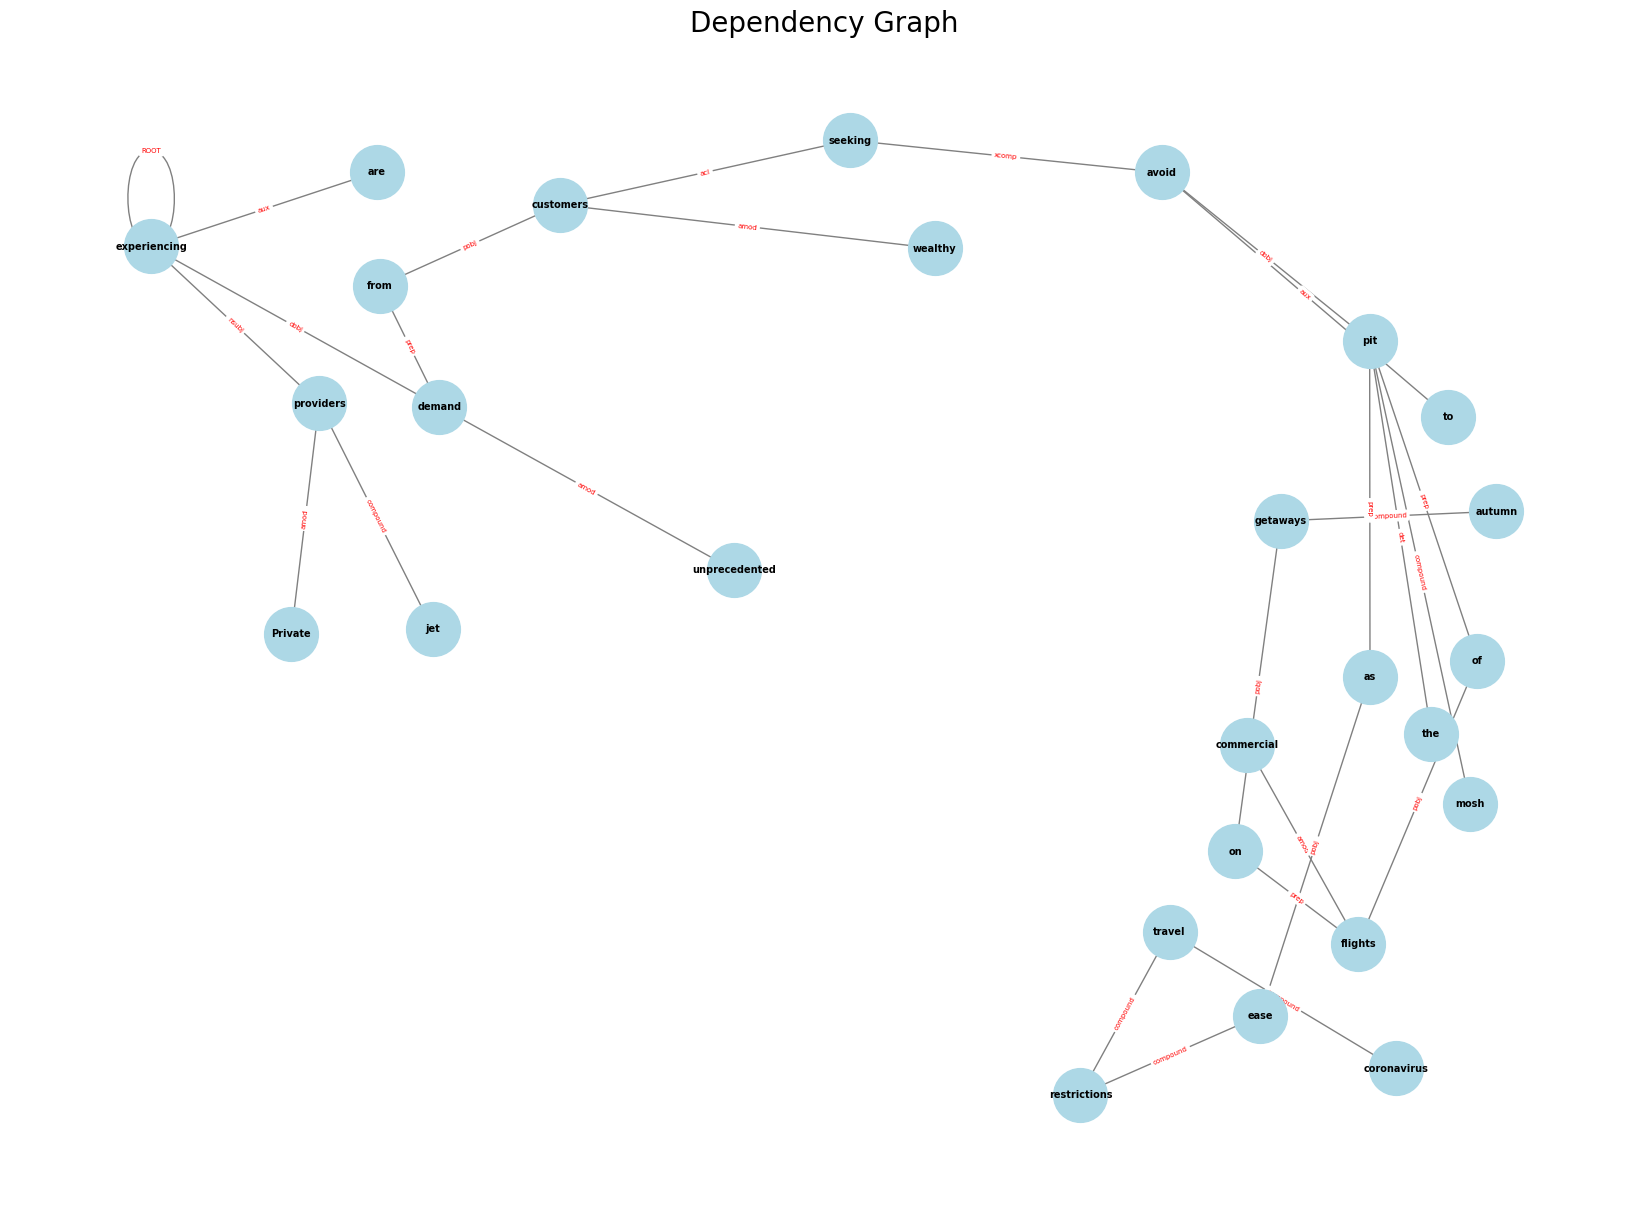

In [ ]:
# The provided data
data = [
    ('Private', 'amod', 'providers'),
    ('jet', 'compound', 'providers'),
    ('providers', 'nsubj', 'experiencing'),
    ('are', 'aux', 'experiencing'),
    ('experiencing', 'ROOT', 'experiencing'),
    ('unprecedented', 'amod', 'demand'),
    ('demand', 'dobj', 'experiencing'),
    ('from', 'prep', 'demand'),
    ('wealthy', 'amod', 'customers'),
    ('customers', 'pobj', 'from'),
    ('seeking', 'acl', 'customers'),
    ('to', 'aux', 'avoid'),
    ('avoid', 'xcomp', 'seeking'),
    ('the', 'det', 'pit'),
    ('mosh', 'compound', 'pit'),
    ('pit', 'dobj', 'avoid'),
    ('of', 'prep', 'pit'),
    ('commercial', 'amod', 'flights'),
    ('flights', 'pobj', 'of'),
    ('on', 'prep', 'flights'),
    ('autumn', 'compound', 'getaways'),
    ('getaways', 'pobj', 'on'),
    ('as', 'prep', 'pit'),
    ('coronavirus', 'compound', 'travel'),
    ('travel', 'compound', 'restrictions'),
    ('restrictions', 'compound', 'ease'),
    ('ease', 'pobj', 'as'),
]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for source, dep, target in data:
    G.add_edge(source, target, label=dep)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Set up the plot
plt.figure(figsize=(21, 15))  # Set the figure size

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Customize the axes and title
plt.title("Dependency Graph", fontsize=20)
plt.axis('off')  # Turn off the axis

# Show the plot
plt.show()


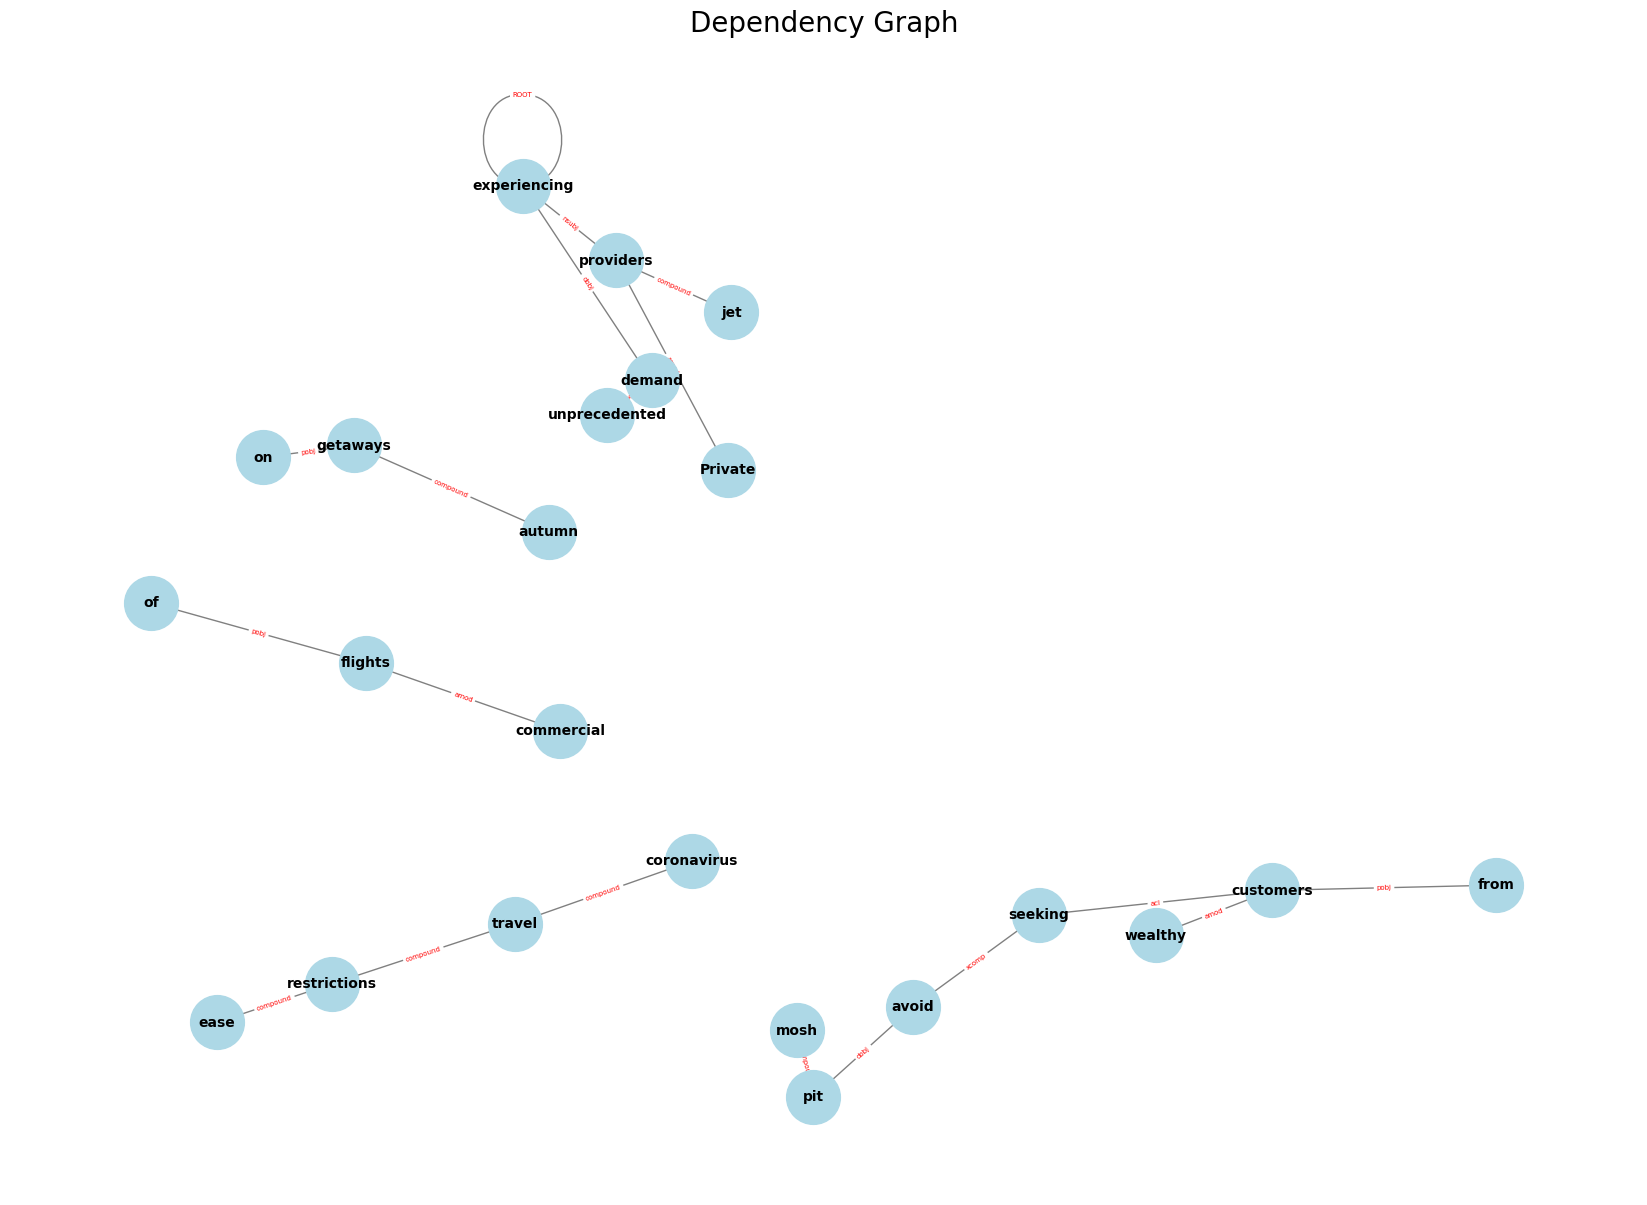

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# The provided data
data = [('Private', 'amod', 'providers'),
 ('jet', 'compound', 'providers'),
 ('providers', 'nsubj', 'experiencing'),
 ('experiencing', 'ROOT', 'experiencing'),
 ('unprecedented', 'amod', 'demand'),
 ('demand', 'dobj', 'experiencing'),
 ('wealthy', 'amod', 'customers'),
 ('customers', 'pobj', 'from'),
 ('seeking', 'acl', 'customers'),
 ('avoid', 'xcomp', 'seeking'),
 ('mosh', 'compound', 'pit'),
 ('pit', 'dobj', 'avoid'),
 ('commercial', 'amod', 'flights'),
 ('flights', 'pobj', 'of'),
 ('autumn', 'compound', 'getaways'),
 ('getaways', 'pobj', 'on'),
 ('coronavirus', 'compound', 'travel'),
 ('travel', 'compound', 'restrictions'),
 ('restrictions', 'compound', 'ease')]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for source, dep, target in data:
    G.add_edge(source, target, label=dep)

# Position nodes using spring layout with a higher value of k for more spacing
pos = nx.spring_layout(G, k=0.3)  # Increase k value to spread out nodes more

# Set up the plot
plt.figure(figsize=(21, 15))  # Set the figure size

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Customize the axes and title
plt.title("Dependency Graph", fontsize=20)
plt.axis('off')  # Turn off the axis

# Save the plot as a PNG file
plt.savefig('dependency_graph.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [3]:
"""
# The provided data
data = lista2

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for source, dep, target in data:
    G.add_edge(source, target, label=dep)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Set up the plot
plt.figure(figsize=(21, 15))  # Set the figure size

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Customize the axes and title
plt.title("Dependency Graph", fontsize=20)
plt.axis('off')  # Turn off the axis

# Show the plot
#plt.show()
"""

'\n# The provided data\ndata = lista2\n\n# Create a directed graph\nG = nx.DiGraph()\n\n# Add edges to the graph\nfor source, dep, target in data:\n    G.add_edge(source, target, label=dep)\n\n# Position nodes using spring layout\npos = nx.spring_layout(G)\n\n# Set up the plot\nplt.figure(figsize=(21, 15))  # Set the figure size\n\n# Draw the nodes\nnx.draw_networkx_nodes(G, pos, node_color=\'lightblue\', node_size=1500)\n\n# Draw the edges\nnx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle=\'-|>\', arrowsize=15, edge_color=\'gray\')\n\n# Draw the labels\nnx.draw_networkx_labels(G, pos, font_size=7, font_weight=\'bold\')\n\n# Draw the edge labels\nedge_labels = nx.get_edge_attributes(G, \'label\')\nnx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color=\'red\', font_size=5)\n\n# Customize the axes and title\nplt.title("Dependency Graph", fontsize=20)\nplt.axis(\'off\')  # Turn off the axis\n\n# Show the plot\n#plt.show()\n'

In [4]:
"""
# The provided data

filtered_data = [
    (word1, dep, word2) for word1, dep, word2 in lista2
    if not (nlp.vocab[word1].is_stop or nlp.vocab[word1].is_punct or
            nlp.vocab[word2].is_stop or nlp.vocab[word2].is_punct)
]

data = filtered_data
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for source, dep, target in data:
    G.add_edge(source, target, label=dep)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Set up the plot
plt.figure(figsize=(21, 15))  # Set the figure size

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Customize the axes and title
plt.title("Dependency Graph", fontsize=20)
plt.axis('off')  # Turn off the axis

# Show the plot
#plt.show()
"""

'\n# The provided data\n\nfiltered_data = [\n    (word1, dep, word2) for word1, dep, word2 in lista2\n    if not (nlp.vocab[word1].is_stop or nlp.vocab[word1].is_punct or\n            nlp.vocab[word2].is_stop or nlp.vocab[word2].is_punct)\n]\n\ndata = filtered_data\n# Create a directed graph\nG = nx.DiGraph()\n\n# Add edges to the graph\nfor source, dep, target in data:\n    G.add_edge(source, target, label=dep)\n\n# Position nodes using spring layout\npos = nx.spring_layout(G)\n\n# Set up the plot\nplt.figure(figsize=(21, 15))  # Set the figure size\n\n# Draw the nodes\nnx.draw_networkx_nodes(G, pos, node_color=\'lightblue\', node_size=1500)\n\n# Draw the edges\nnx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle=\'-|>\', arrowsize=15, edge_color=\'gray\')\n\n# Draw the labels\nnx.draw_networkx_labels(G, pos, font_size=7, font_weight=\'bold\')\n\n# Draw the edge labels\nedge_labels = nx.get_edge_attributes(G, \'label\')\nnx.draw_networkx_edge_labels(G, pos, edge_labels=edge_

# NLTK Chomsky Tree

In [ ]:
import nltk
from nltk import Tree

# Function to convert spaCy parse tree to nltk Tree
def to_nltk_tree(node):
    if not list(node.children):
        return f"{node.text}/{node.dep_}"
    return Tree(f"{node.text}/{node.dep_}", [to_nltk_tree(child) for child in node.children])

# Convert the spaCy parse tree to nltk Tree
nltk_tree = to_nltk_tree([sent.root for sent in doc.sents][0])

# Draw the tree
nltk_tree.pretty_print()


                                                                                                                                 said/ROOT                                                                                                                                          
    _________________________________________________________________________________________________________________________________|________________________________________________________________                                                                               
   |                                           Flexjet/nsubj                                                                                                                                    experiencing/                                                                       
   |                                                 |                                                                                                                  

# Spacy processor final

In [ ]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

def spacy_processor(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # List to hold the results for each sentence
    nested_list = []

    # Iterate over the sentences in the document
    for sent in doc.sents:
        lista = []
        # Extract dependencies for each token in the sentence
        for token in sent:
            lista.extend([(token.text, token.pos_, token.dep_, token.head.text)])

        # Filter out stopwords and punctuation
        filtered_data = [
            (word1, pos, dep, word2) for word1, pos, dep, word2 in lista
            if not (nlp.vocab[word1].is_stop or nlp.vocab[word1].is_punct)
        ]
        # Add the filtered data to the nested list
        nested_list.append(filtered_data)

    #return nested_list
    return nested_list

In [ ]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

def spacy_stop_punc_removal(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # List to hold the filtered tokens
    filtered_tokens = []

    # Iterate over each token in the document
    for token in doc:
        # Filter out stopwords and punctuation
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.text)

    # Join the filtered tokens to form the cleaned text
    cleaned_text = " ".join(filtered_tokens)

    return cleaned_text

In [ ]:
def print_cpu_ram_usage():
    # Get CPU and RAM usage
    cpu_percent = psutil.cpu_percent(interval=1)
    ram_percent = psutil.virtual_memory().percent
    print(f"CPU Usage: {cpu_percent}%")
    print(f"RAM Usage: {ram_percent}%")

def print_gpu_usage():
    # Get GPU usage
    gpus = GPUtil.getGPUs()
    list_gpus = []
    for gpu in gpus:
        gpu_id = gpu.id
        gpu_name = gpu.name
        gpu_load = f"{gpu.load * 100:.0f}%"
        gpu_free_memory = f"{gpu.memoryFree}MB"
        gpu_used_memory = f"{gpu.memoryUsed}MB"
        gpu_total_memory = f"{gpu.memoryTotal}MB"
        list_gpus.append((gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory, gpu_total_memory))

    print(tabulate(list_gpus, headers=("GPU ID", "GPU Name", "GPU Load", "GPU Free Memory", "GPU Used Memory", "GPU Total Memory")))

In [ ]:
teste = spacy_processor(df.iloc[0].content)
#teste

In [ ]:
#sentencetest = df.iloc[0]['Spacy Processed Sentences']

In [ ]:
import spacy
import textacy
import matplotlib.pylab as plt
import networkx as nx

# Load spacy model
nlp = spacy.load('en_core_web_sm')
# Plain text

# Process plain text with spacy
doc = nlp(tr[1])

# Extract SVO list from spacy object
triples = list(textacy.extract.subject_verb_object_triples(doc))

print(triples)
# [SVOTriple(subject=[I], verb=[am, going], object=[to, extract, SVO])]

ModuleNotFoundError: No module named 'textacy'

In [ ]:
# Add edges to the graph
for i in range(len(teste)):
  print(teste[i])

[('Private', 'ADJ', 'amod', 'providers'), ('jet', 'NOUN', 'compound', 'providers'), ('providers', 'NOUN', 'nsubj', 'experiencing'), ('experiencing', 'VERB', 'ROOT', 'experiencing'), ('unprecedented', 'ADJ', 'amod', 'demand'), ('demand', 'NOUN', 'dobj', 'experiencing'), ('wealthy', 'ADJ', 'amod', 'customers'), ('customers', 'NOUN', 'pobj', 'from'), ('seeking', 'VERB', 'acl', 'customers'), ('avoid', 'VERB', 'xcomp', 'seeking'), ('mosh', 'PROPN', 'compound', 'pit'), ('pit', 'NOUN', 'dobj', 'avoid'), ('commercial', 'ADJ', 'amod', 'flights'), ('flights', 'NOUN', 'pobj', 'of'), ('autumn', 'NOUN', 'compound', 'getaways'), ('getaways', 'NOUN', 'pobj', 'on'), ('coronavirus', 'NOUN', 'compound', 'travel'), ('travel', 'NOUN', 'compound', 'restrictions'), ('restrictions', 'NOUN', 'compound', 'ease'), ('ease', 'NOUN', 'pobj', 'as')]
[('Flexjet', 'PROPN', 'nsubj', 'said'), ('PrivateFly', 'PROPN', 'conj', 'Flexjet'), ('supply', 'VERB', 'relcl', 'Flexjet'), ('private', 'ADJ', 'amod', 'jets'), ('jets',

In [ ]:
G = nx.DiGraph()

l = []

# Add edges to the graph
for i in range(len(teste)):
  for source, pos, dep, target in teste[i]:
      G.add_edge(source, target, label=dep)

  # Find all weakly connected components in the graph
  components = list(nx.weakly_connected_components(G))
  l.append(components)

In [ ]:
#l

In [ ]:
G = nx.DiGraph()

l = []

# Add edges to the graph
for sentence in teste:
  for source, pos, dep, target in sentence:
      G.add_edge(source, target, label=dep)

  # Find all weakly connected components in the graph
  components = list(nx.weakly_connected_components(G))
  # Keep only components with more than one word
  filtered_components = [component for component in components if len(component) > 1]
  l.append(filtered_components)

filtered_list = [component for sublist in l for component in sublist if len(component) > 1]

In [ ]:
#df.iloc[0].content

In [ ]:
#filtered_list

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# First, create a dictionary to map words to their dependencies
dep_map = {word: dep for word, pos, dep, head in teste[2]}

# Add edges to the graph and add node attributes for POS, Dependency, Head, and Head Dependency
for source, pos, dep, target in teste[2]:
    head_dep = dep_map.get(target, 'N/A')
    G.add_node(source, pos=pos, dep=dep, head=target, head_dep=head_dep)
    G.add_node(target)  # Ensure the target node is also added
    G.add_edge(source, target, label=dep)

# Function to get node attributes
def get_node_attributes(graph, node):
    pos = graph.nodes[node].get('pos', 'N/A')
    dep = graph.nodes[node].get('dep', 'N/A')
    head = graph.nodes[node].get('head', 'N/A')
    return pos, dep, head

# Find all weakly connected components in the graph
components = list(nx.weakly_connected_components(G))

components_infos = []
# Print each component with node attributes
for component in components:
    component_info = []
    for node in component:
        pos, dep, head= get_node_attributes(G, node)
        component_info.append((node, pos, dep, head))
    components_infos.append(component_info)

components_infos

[[('said', 'VERB', 'ROOT', 'said'),
  ('Flexjet', 'PROPN', 'nsubj', 'said'),
  ('usual', 'ADJ', 'amod', 'trends'),
  ('seasonal', 'ADJ', 'amod', 'trends'),
  ('flights', 'NOUN', 'dobj', 'operated'),
  ('ownership', 'NOUN', 'dobj', 'offers'),
  ('operated', 'VERB', 'ccomp', 'said'),
  ('offers', 'VERB', 'relcl', 'Flexjet'),
  ('shared', 'VERB', 'amod', 'ownership'),
  ('bucking', 'VERB', 'advcl', 'operated'),
  ('trends', 'NOUN', 'dobj', 'bucking')],
 [('September', 'PROPN', 'pobj', 'in'),
  ('fleet', 'NOUN', 'pobj', 'in'),
  ('Europe', 'PROPN', 'pobj', 'in'),
  ('in', 'N/A', 'N/A', 'N/A')],
 [('private', 'ADJ', 'amod', 'jets'),
  ('jets', 'NOUN', 'pobj', 'of'),
  ('of', 'N/A', 'N/A', 'N/A')],
 [('%', 'N/A', 'N/A', 'N/A'), ('53', 'NUM', 'nummod', '%')],
 [('previous', 'ADJ', 'amod', 'month'),
  ('month', 'NOUN', 'pobj', 'than'),
  ('than', 'N/A', 'N/A', 'N/A')]]

In [ ]:
# Function to get node attributes
def get_node_attributes(graph, node):
    pos = graph.nodes[node].get('pos', 'N/A')
    dep = graph.nodes[node].get('dep', 'N/A')
    head = graph.nodes[node].get('head', 'N/A')
    return pos, dep, head

def xx(text):
  li = []
  for i in range(len(text)):
  # Create a directed graph
    G = nx.DiGraph()

    # First, create a dictionary to map words to their dependencies
    dep_map = {word: dep for word, pos, dep, head in text[i]}

    # Add edges to the graph and add node attributes for POS, Dependency, Head, and Head Dependency
    for source, pos, dep, target in teste[i]:
        head_dep = dep_map.get(target, 'N/A')
        G.add_node(source, pos=pos, dep=dep, head=target, head_dep=head_dep)
        G.add_node(target)  # Ensure the target node is also added
        G.add_edge(source, target, label=dep)

    # Find all weakly connected components in the graph
    components = list(nx.weakly_connected_components(G))

    components_infos = []
    # Print each component with node attributes
    for component in components:
        component_info = []
        for node in component:
            pos, dep, head= get_node_attributes(G, node)
            component_info.append((node, pos, dep, head))
        components_infos.append(component_info)

    li.append(components_infos)
  return li

In [ ]:
#xx(teste)

In [ ]:
#df.iloc[0].content

In [ ]:
#components_infos[0]

In [ ]:

subjects_adj = []
verbs_adj = []
obejctts_adj = []
svo = []

subject = ''
verb = ''
objectt = ''

svo = ()
for word, pos, dep, head in components_infos[0]:
    if (pos == 'NOUN' or pos == 'PROPN' or pos == 'PRON') and (dep == 'nsubj' or dep == 'nsubjpass'):
        subject = word
    if pos == 'VERB' and dep == 'ROOT':
        verb = word
    if pos == 'NOUN' and (dep == 'dobj' or dep == 'iobj' or dep =='pobj'):
        objectt = word

if verb == '':
  for word, pos, dep, head in components_infos[0]:
      if pos == 'VERB':
        verb = word

if subject == '':
  for word, pos, dep, head in components_infos[0]:
    if pos == 'NOUN' and (dep == 'pobj'):
      subject = word
    if pos == 'NOUN' and (dep == 'dobj'):
      objectt = word


for word, pos, dep, head in components_infos[0]:
  if head ==  subject and head != word and pos != 'VERB':
    subjects_adj.append(word)
  if (head ==  objectt and head != word) or (pos == 'NOUN' and dep == 'dobj' and word != objectt):
    obejctts_adj.append(word)
  if head == verb and dep not in ('nsubj', 'dobj') and head != word:
    verbs_adj.append(word)

if subjects_adj:
  merged_subject = " ".join(subjects_adj) + " " + subject
else:
  merged_subject = subject
if verbs_adj:
  merged_verbs = verb + " " + " ".join(verbs_adj)
else:
  merged_verbs = verb
if obejctts_adj:
  merged_objects = " ".join(obejctts_adj) + " " + objectt
else:
  merged_objects = objectt

svo = (merged_subject, merged_verbs, merged_objects)
print(svo)

('Flexjet', 'said operated', 'usual seasonal flights ownership trends')


In [ ]:
def yy(component_info):

  svos = []

  for i in range(len(component_info)):

    subjects_adj = []
    verbs_adj = []
    obejctts_adj = []
    svo = []

    subject = ''
    verb = ''
    objectt = ''

    svo = ()


    for word, pos, dep, head in component_info[i]:
        if (pos == 'NOUN' or pos == 'PROPN' or pos == 'PRON') and (dep == 'nsubj' or dep == 'nsubjpass'):
            subject = word
        if pos == 'VERB' and dep == 'ROOT':
            verb = word
        if pos == 'NOUN' and (dep == 'dobj' or dep == 'iobj' or dep =='pobj'):
            objectt = word

    if verb == '':
      for word, pos, dep, head in component_info[i]:
          if pos == 'VERB':
            verb = word

    if subject == '':
      for word, pos, dep, head in component_info[i]:
        if pos == 'NOUN' and (dep == 'pobj'):
          subject = word
        if pos == 'NOUN' and (dep == 'dobj'):
          objectt = word

    if verb != '':

      for word, pos, dep, head in component_info[i]:
        if head ==  subject and head != word and pos != 'VERB':
          subjects_adj.append(word)
        if (head ==  objectt and head != word) or (pos == 'NOUN' and dep == 'dobj' and word != objectt):
          obejctts_adj.append(word)
        if head == verb and dep not in ('nsubj', 'dobj') and head != word:
          verbs_adj.append(word)

      if subjects_adj:
        merged_subject = " ".join(subjects_adj) + " " + subject
      else:
        merged_subject = subject
      if verbs_adj:
        merged_verbs = verb + " " + " ".join(verbs_adj)
      else:
        merged_verbs = verb
      if obejctts_adj:
        merged_objects = " ".join(obejctts_adj) + " " + objectt
      else:
        merged_objects = objectt

      svo = (merged_subject, merged_verbs, merged_objects)

      svos.append(svo)

  return svos

In [ ]:
yy(components_infos)

[('Flexjet', 'said operated', 'usual seasonal flights ownership trends')]

In [ ]:
df.iloc[0].content

'Private jet providers are experiencing “unprecedented demand” from wealthy customers seeking to avoid the “mosh pit” of commercial flights on autumn getaways as coronavirus travel restrictions ease. Flexjet and PrivateFly, which supply private jets to rich families and business executives, said they were “experiencing exceptionally strong demand” for September and October travel at a time of year when bookings normally fall away. Flexjet, which offers shared ownership in its fleet of private jets in Europe, said it operated 53% more flights in September than the previous month, bucking the usual seasonal trends. Marine Eugène, the European managing director of Flexjet and PrivateFly, said: “Our industry in Europe traditionally sees a significant peak in July and August, followed by a tailing off in September – but not this year. “We are currently experiencing exceptionally strong demand, with the appetite for personal travel not yet sated after a later start to summer due to restricti

In [ ]:
components_infos

[[('said', 'VERB', 'ROOT', 'said'),
  ('Flexjet', 'PROPN', 'nsubj', 'said'),
  ('usual', 'ADJ', 'amod', 'trends'),
  ('seasonal', 'ADJ', 'amod', 'trends'),
  ('flights', 'NOUN', 'dobj', 'operated'),
  ('ownership', 'NOUN', 'dobj', 'offers'),
  ('operated', 'VERB', 'ccomp', 'said'),
  ('offers', 'VERB', 'relcl', 'Flexjet'),
  ('shared', 'VERB', 'amod', 'ownership'),
  ('bucking', 'VERB', 'advcl', 'operated'),
  ('trends', 'NOUN', 'dobj', 'bucking')],
 [('September', 'PROPN', 'pobj', 'in'),
  ('fleet', 'NOUN', 'pobj', 'in'),
  ('Europe', 'PROPN', 'pobj', 'in'),
  ('in', 'N/A', 'N/A', 'N/A')],
 [('private', 'ADJ', 'amod', 'jets'),
  ('jets', 'NOUN', 'pobj', 'of'),
  ('of', 'N/A', 'N/A', 'N/A')],
 [('%', 'N/A', 'N/A', 'N/A'), ('53', 'NUM', 'nummod', '%')],
 [('previous', 'ADJ', 'amod', 'month'),
  ('month', 'NOUN', 'pobj', 'than'),
  ('than', 'N/A', 'N/A', 'N/A')]]

In [ ]:
# Initialize empty dictionaries to hold adjectives and adverbs related to subjects and objects
subject_modifiers = {}
object_modifiers = {}

# Identify the subject and object of the sentence
subject = None
objects = []

for word, pos, dep, head in components_infos:
    if dep == 'nsubj':
        subject = head
        subject_modifiers[head] = []
    elif dep in ('dobj', 'pobj'):
        objects.append(head)
        object_modifiers[head] = []

# Extract adjectives and adverbs related to the subject and objects
for word, pos, dep, head in sentencetest:
    if dep in ('amod', 'compound') and head in subject_modifiers:
        subject_modifiers[head].append(word)
    elif dep in ('amod', 'compound') and head in object_modifiers:
        object_modifiers[head].append(word)

# Output the results
print("Subject Modifiers:")
for subj, modifiers in subject_modifiers.items():
    print(f"{subj}: {modifiers}")

print("\nObject Modifiers:")
for obj, modifiers in object_modifiers.items():
    print(f"{obj}: {modifiers}")

ValueError: too many values to unpack (expected 4)

In [ ]:
def get_svos(sentence):
  subjects = []
  verbs = []
  objects = []
  svo = []

  for item in sentence:
    # adjectives of subejcts
    if item[1] ==  'ADJ' and (item[4] == 'nsubj' or item[4] == 'nsubjpass'):
      subjects.append(item[0])
    if item[1] ==  'NOUN' and (item[4] == 'nsubj' or item[4] == 'nsubjpass'):
      subjects.append(item[0])
    # subjects
    if item[1] == 'NOUN' and (item[2] == 'nsubj' or item[2] == 'nsubjpass'):
      subjects.append(item[0])
    # verbs
    if item[1] == 'VERB':
      verbs.append(item[0])
    # adjectives of objects
    if item[1] ==  'ADJ' and (item[4] == 'dobj' or item[4] == 'pobj'):
      objects.append(item[0])
    if item[1] ==  'NOUN' and (item[4] == 'dobj' or item[4] == 'pobj'):
      subjects.append(item[0])
    # objects
    if item[1] == 'NOUN' and (item[2] == 'dobj' or item[2] == 'pobj'):
      objects.append(item[0])
  svo.extend([subjects, verbs, objects])
  return svo

In [ ]:
get_svos(components_infos[1])

In [ ]:
get_svos(components_infos[0])

In [ ]:
def extract_svo_triplet(dependencies):
    subject_group = []
    verb_group = []
    object_group = []

    # Identify the main subject, verb, and object
    main_subject = None
    main_verb = None
    main_object = None

    # Create a lookup for words referring to other words
    ref_dict = {word: head for word, pos, dep, head in dependencies}

    # Process each dependency to group related words
    for word, pos, dep, head in dependencies:
        if dep in {'nsubj', 'nsubjpass'}:
            main_subject = word
            subject_group.append((word, pos, dep, head))
        elif dep == 'ROOT':
            main_verb = word
            verb_group.append((word, pos, dep, head))
        elif dep in {'dobj', 'attr', 'prep', 'pobj'}:
            main_object = word
            object_group.append((word, pos, dep, head))
        else:
            if dep in {'amod', 'compound'}:
                if head == main_subject:
                    subject_group.append((word, pos, dep, head))
                elif head == main_verb:
                    verb_group.append((word, pos, dep, head))
                elif head == main_object:
                    object_group.append((word, pos, dep, head))

    # Helper function to create phrases from groups
    def create_phrase(group):
        return ' '.join([word for word, pos, dep, head in sorted(group, key=lambda x: ref_dict.get(x[0], ''))])

    # Create the subject, verb, and object phrases
    subject_phrase = create_phrase(subject_group)
    verb_phrase = create_phrase(verb_group)
    object_phrase = create_phrase(object_group)

    return (subject_phrase, verb_phrase, object_phrase)

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# First, create a dictionary to map words to their dependencies
dep_map = {word: dep for word, pos, dep, head in teste[0]}

# Add edges to the graph and add node attributes for POS, Dependency, Head, and Head Dependency
for source, pos, dep, target in teste[0]:
    head_dep = dep_map.get(target, 'N/A')
    G.add_node(source, pos=pos, dep=dep, head=target, head_dep=head_dep)
    G.add_node(target)  # Ensure the target node is also added
    G.add_edge(source, target, label=dep)

# Function to get node attributes
def get_node_attributes(graph, node):
    pos = graph.nodes[node].get('pos', 'N/A')
    return pos

# Find all weakly connected components in the graph
components = list(nx.weakly_connected_components(G))

components_infos = []
# Print each component with node attributes
for component in components:
    component_info = []
    for node in component:
        pos= get_node_attributes(G, node)
        component_info.append((node, pos))
    components_infos.append(component_info)

components_infos

[[('unprecedented', 'ADJ'),
  ('Private', 'ADJ'),
  ('experiencing', 'VERB'),
  ('providers', 'NOUN'),
  ('demand', 'NOUN'),
  ('jet', 'NOUN')],
 [('avoid', 'VERB'),
  ('customers', 'NOUN'),
  ('wealthy', 'ADJ'),
  ('mosh', 'PROPN'),
  ('pit', 'NOUN'),
  ('seeking', 'VERB'),
  ('from', 'N/A')],
 [('flights', 'NOUN'), ('commercial', 'ADJ'), ('of', 'N/A')],
 [('getaways', 'NOUN'), ('autumn', 'NOUN'), ('on', 'N/A')],
 [('coronavirus', 'NOUN'),
  ('travel', 'NOUN'),
  ('ease', 'NOUN'),
  ('restrictions', 'NOUN'),
  ('as', 'N/A')]]

In [ ]:
teste

[[('Private', 'ADJ', 'amod', 'providers'),
  ('jet', 'NOUN', 'compound', 'providers'),
  ('providers', 'NOUN', 'nsubj', 'experiencing'),
  ('experiencing', 'VERB', 'ROOT', 'experiencing'),
  ('unprecedented', 'ADJ', 'amod', 'demand'),
  ('demand', 'NOUN', 'dobj', 'experiencing'),
  ('wealthy', 'ADJ', 'amod', 'customers'),
  ('customers', 'NOUN', 'pobj', 'from'),
  ('seeking', 'VERB', 'acl', 'customers'),
  ('avoid', 'VERB', 'xcomp', 'seeking'),
  ('mosh', 'PROPN', 'compound', 'pit'),
  ('pit', 'NOUN', 'dobj', 'avoid'),
  ('commercial', 'ADJ', 'amod', 'flights'),
  ('flights', 'NOUN', 'pobj', 'of'),
  ('autumn', 'NOUN', 'compound', 'getaways'),
  ('getaways', 'NOUN', 'pobj', 'on'),
  ('coronavirus', 'NOUN', 'compound', 'travel'),
  ('travel', 'NOUN', 'compound', 'restrictions'),
  ('restrictions', 'NOUN', 'compound', 'ease'),
  ('ease', 'NOUN', 'pobj', 'as')],
 [('Flexjet', 'PROPN', 'nsubj', 'said'),
  ('PrivateFly', 'PROPN', 'conj', 'Flexjet'),
  ('supply', 'VERB', 'relcl', 'Flexjet'),

In [ ]:
svo_triplet = extract_svo_triplet(components_infos[1])

In [ ]:
teste = spacy_processor(df.iloc[0].content)
teste

In [ ]:
components_infos

[[('unprecedented', 'ADJ'),
  ('Private', 'ADJ'),
  ('experiencing', 'VERB'),
  ('providers', 'NOUN'),
  ('demand', 'NOUN'),
  ('jet', 'NOUN')],
 [('avoid', 'VERB'),
  ('customers', 'NOUN'),
  ('wealthy', 'ADJ'),
  ('mosh', 'PROPN'),
  ('pit', 'NOUN'),
  ('seeking', 'VERB'),
  ('from', 'N/A')],
 [('flights', 'NOUN'), ('commercial', 'ADJ'), ('of', 'N/A')],
 [('getaways', 'NOUN'), ('autumn', 'NOUN'), ('on', 'N/A')],
 [('coronavirus', 'NOUN'),
  ('travel', 'NOUN'),
  ('ease', 'NOUN'),
  ('restrictions', 'NOUN'),
  ('as', 'N/A')]]

In [ ]:
import matplotlib.pyplot as plt

# The provided data
data = components_infos[0]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for source, pos, dep, target in data:
    G.add_edge(source, target, label=dep)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Set up the plot
plt.figure(figsize=(21, 15))  # Set the figure size

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Customize the axes and title
plt.title("Dependency Graph", fontsize=20)
plt.axis('off')  # Turn off the axis

# Show the plot
plt.show()

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
def extract_svo(doc):
    svos = []

    for token in doc:
        # Identify the subject
        if token.dep_ in {"nsubj", "nsubjpass"}:
            subject = token.text
            verb = token.head
            objects = []

            # Identify direct objects and their modifiers
            for child in verb.children:
                if child.dep_ in {"dobj", "attr"}:
                    objects.append(child)
                # Identify objects of prepositional phrases
                elif child.dep_ == "prep":
                    for pobj in child.children:
                        if pobj.dep_ == "pobj":
                            objects.append(f"{child.text} {pobj.text}")

            # Include clausal complements (ccomp) and xcomps
            for child in verb.children:
                if child.dep_ in {"ccomp", "xcomp"}:
                    objects.append(child)

            # Store the SVO triplets
            if objects:
                for obj in objects:
                    svos.append((subject, verb.lemma_, obj.text if isinstance(obj, spacy.tokens.Token) else obj))
            else:
                # If no direct objects, add the verb alone as a triplet
                svos.append((subject, verb.lemma_, None))

    return svos

In [ ]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

def extract_svo(doc):
    svos = []

    for token in doc:
        # Identify the subject
        if token.dep_ in {"nsubj", "nsubjpass"}:
            subject = token.text
            verb = token.head
            objects = []

            # Identify direct objects and their modifiers
            for child in verb.children:
                if child.dep_ in {"dobj", "attr"}:
                    objects.append(child)
                # Identify objects of prepositional phrases
                elif child.dep_ == "prep":
                    for pobj in child.children:
                        if pobj.dep_ == "pobj":
                            objects.append(f"{child.text} {pobj.text}")

            # Include clausal complements (ccomp) and xcomps
            for child in verb.children:
                if child.dep_ in {"ccomp", "xcomp"}:
                    objects.append(child)

            # Store the SVO triplets
            if objects:
                for obj in objects:
                    svos.append((subject, verb.lemma_, obj.text if isinstance(obj, spacy.tokens.Token) else obj))
            else:
                # If no direct objects, add the verb alone as a triplet
                svos.append((subject, verb.lemma_, None))

    return svos

# Test the function with the provided sentence
sentence = "Private jet providers are experiencing “unprecedented demand” from wealthy customers seeking to avoid the “mosh pit” of commercial flights on autumn getaways as coronavirus travel restrictions ease."
doc = nlp(sentence)

svos = extract_svo(doc)
for svo in svos:
    print(f"Subject: {svo[0]}, Verb: {svo[1]}, Object: {svo[2]}")


- Subject: providers, Verb: experience, Object: unprecedented demand
- Subject: customers, Verb: seek, Object: to avoid
- Subject: restrictions, Verb: ease, Object: None

# Explanation

In spaCy, the dep_ attribute of a token indicates its syntactic dependency, representing the relationship between a token and its head within the sentence's syntactic structure. Here are the possible dependency labels (dep_ values) and their meanings:

- acl (clausal modifier of noun): A clause that modifies a noun.

Example: "The book that you gave me"
- acomp (adjectival complement): An adjectival phrase that follows a copular verb and describes the subject.

Example: "She is happy"
- advcl (adverbial clause modifier): A clause that modifies a verb, adjective, or adverb.

Example: "She left because it was late"
- advmod (adverbial modifier): An adverb that modifies a verb, adjective, or another adverb.

Example: "He ran quickly"
- agent (agent): The noun phrase that represents the agent in a passive construction.

Example: "The cake was eaten by the dog"
- amod (adjectival modifier): An adjective that modifies a noun.

Example: "The red car"
- appos (appositional modifier): A noun or noun phrase that renames another noun right beside it.

Example: "My friend, a doctor, will see you now"
- attr (attribute): An attribute of the subject following a copular verb.

Example: "She is a teacher"
- aux (auxiliary): An auxiliary verb.

Example: "She is running"
- auxpass (passive auxiliary): An auxiliary verb in a passive construction.

Example: "The cake was eaten"
- case (case marker): A word marking a noun's grammatical case.

Example: "He sat on the chair"
- cc (coordinating conjunction): A coordinating conjunction.

Example: "We have apples and oranges"
- ccomp (clausal complement): A clause that serves as a complement.

Example: "I know that you are coming"
- compound (compound): A compound word or phrase.

Example: "Credit card"
- conj (conjunct): A conjunct in a coordination.

Example: "We have apples and oranges"
- cop (copula): A copular verb.

Example: "She is a teacher"
- csubj (clausal subject): A clause that functions as the subject.

Example: "What she said was surprising"
- csubjpass (clausal passive subject): A clause that functions as the subject of a passive verb.

Example: "That he was promoted was well known"
- dative (dative): The indirect object of a verb.

Example: "She gave him a gift"
- dep (unclassified dependent): A dependency that doesn't fit any other category.

Example: "He is a good boy"
- det (determiner): A determiner.

Example: "The car is red"
- dobj (direct object): The direct object of a verb.

Example: "She reads the book"
- expl (expletive): An expletive word.

Example: "There is a cat on the roof"
- intj (interjection): An interjection.

Example: "Wow, that's amazing!"
- mark (marker): A word introducing a subordinate clause.

Example: "She left because it was late"
- meta (meta modifier): A metatextual element.

Example: "The book, frankly, is not good"
- neg (negation modifier): A negation modifier.

Example: "She does not like it"
- nounmod (noun modifier): A noun that modifies another noun.

Example: "Oil company"
- npadvmod (noun phrase adverbial modifier): A noun phrase that functions as an adverbial modifier.

Example: "He arrived last night"
- nsubj (nominal subject): The subject of a clause.

Example: "She runs fast"
- nsubjpass (passive nominal subject): The subject of a passive verb.

Example: "The cake was eaten"
- nummod (numeric modifier): A number that modifies a noun.

Example: "Three cars"
- oprd (object predicate): An object predicate.

Example: "They elected him president"
- parataxis (parataxis): A relationship between two elements that are side-by-side but do not have a clear syntactic relationship.

Example: "We went to the park, he played football"
- pcomp (prepositional complement): The complement of a preposition.

Example: "He is responsible for doing that"
- pobj (object of preposition): The object of a preposition.

Example: "He sat on the chair"
- poss (possession modifier): A possessive modifier.

Example: "John's book"
- preconj (pre-correlative conjunction): A conjunction that appears before a correlative conjunction.

Example: "Neither rain nor snow"
- prep (prepositional modifier): A prepositional modifier.

Example: "He arrived in the morning"
- prt (particle): A particle.

Example: "She gave up"
- punct (punctuation): Punctuation.

Example: "Hello, world!"
- quantmod (quantifier modifier): A quantifier phrase modifier.

Example: "He made all the preparations"
- relcl (relative clause modifier): A relative clause modifier.

Example: "The book that I read"
- root (root): The root of the sentence.

Example: "She runs fast"
- xcomp (open clausal complement): An open clausal complement.

Example: "She wants to leave"

In [ ]:
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd"]
ADJECTIVES = ["acomp", "advcl", "advmod", "amod", "appos", "nn", "nmod", "ccomp", "complm", "hmod", "infmod", "xcomp",
              "rcmod", "poss", " possessive"]
COMPOUNDS = ["compound"]
PREPOSITIONS = ["prep"]


def getSubsFromConjunctions(subs):
    moreSubs = []
    for sub in subs:
        # rights is a generator
        rights = list(sub.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if "and" in rightDeps:
            moreSubs.extend([tok for tok in rights if tok.dep_ in SUBJECTS or tok.pos_ == "NOUN"])
            if len(moreSubs) > 0:
                moreSubs.extend(getSubsFromConjunctions(moreSubs))
    return moreSubs


def getObjsFromConjunctions(objs):
    moreObjs = []
    for obj in objs:
        # rights is a generator
        rights = list(obj.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if "and" in rightDeps:
            moreObjs.extend([tok for tok in rights if tok.dep_ in OBJECTS or tok.pos_ == "NOUN"])
            if len(moreObjs) > 0:
                moreObjs.extend(getObjsFromConjunctions(moreObjs))
    return moreObjs


def getVerbsFromConjunctions(verbs):
    moreVerbs = []
    for verb in verbs:
        rightDeps = {tok.lower_ for tok in verb.rights}
        if "and" in rightDeps:
            moreVerbs.extend([tok for tok in verb.rights if tok.pos_ == "VERB"])
            if len(moreVerbs) > 0:
                moreVerbs.extend(getVerbsFromConjunctions(moreVerbs))
    return moreVerbs


def findSubs(tok):
    head = tok.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
        subs = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subs) > 0:
            verbNegated = isNegated(head)
            subs.extend(getSubsFromConjunctions(subs))
            return subs, verbNegated
        elif head.head != head:
            return findSubs(head)
    elif head.pos_ == "NOUN":
        return [head], isNegated(tok)
    return [], False


def isNegated(tok):
    negations = {"no", "not", "n't", "never", "none"}
    for dep in list(tok.lefts) + list(tok.rights):
        if dep.lower_ in negations:
            return True
    return False


def findSVs(tokens):
    svs = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB"]
    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        if len(subs) > 0:
            for sub in subs:
                svs.append((sub.orth_, "!" + v.orth_ if verbNegated else v.orth_))
    return svs


def getObjsFromPrepositions(deps):
    objs = []
    for dep in deps:
        if dep.pos_ == "ADP" and dep.dep_ == "prep":
            objs.extend(
                [tok for tok in dep.rights if tok.dep_ in OBJECTS or (tok.pos_ == "PRON" and tok.lower_ == "me")])
    return objs


def getAdjectives(toks):
    toks_with_adjectives = []
    for tok in toks:
        adjs = [left for left in tok.lefts if left.dep_ in ADJECTIVES]
        adjs.append(tok)
        adjs.extend([right for right in tok.rights if tok.dep_ in ADJECTIVES])
        tok_with_adj = " ".join([adj.lower_ for adj in adjs])
        toks_with_adjectives.extend(adjs)

    return toks_with_adjectives


def getObjsFromAttrs(deps):
    for dep in deps:
        if dep.pos_ == "NOUN" and dep.dep_ == "attr":
            verbs = [tok for tok in dep.rights if tok.pos_ == "VERB"]
            if len(verbs) > 0:
                for v in verbs:
                    rights = list(v.rights)
                    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
                    objs.extend(getObjsFromPrepositions(rights))
                    if len(objs) > 0:
                        return v, objs
    return None, None


def getObjFromXComp(deps):
    for dep in deps:
        if dep.pos_ == "VERB" and dep.dep_ == "xcomp":
            v = dep
            rights = list(v.rights)
            objs = [tok for tok in rights if tok.dep_ in OBJECTS]
            objs.extend(getObjsFromPrepositions(rights))
            if len(objs) > 0:
                return v, objs
    return None, None


def getAllSubs(v):
    verbNegated = isNegated(v)
    subs = [tok for tok in v.lefts if tok.dep_ in SUBJECTS and tok.pos_ != "DET"]
    if len(subs) > 0:
        subs.extend(getSubsFromConjunctions(subs))
    else:
        foundSubs, verbNegated = findSubs(v)
        subs.extend(foundSubs)
    return subs, verbNegated


def getAllObjs(v):
    # rights is a generator
    rights = list(v.rights)
    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
    objs.extend(getObjsFromPrepositions(rights))

    potentialNewVerb, potentialNewObjs = getObjFromXComp(rights)
    if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
        objs.extend(potentialNewObjs)
        v = potentialNewVerb
    if len(objs) > 0:
        objs.extend(getObjsFromConjunctions(objs))
    return v, objs


def getAllObjsWithAdjectives(v):
    # rights is a generator
    rights = list(v.rights)
    objs = [tok for tok in rights if tok.dep_ in OBJECTS]

    if len(objs) == 0:
        objs = [tok for tok in rights if tok.dep_ in ADJECTIVES]

    objs.extend(getObjsFromPrepositions(rights))

    potentialNewVerb, potentialNewObjs = getObjFromXComp(rights)
    if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
        objs.extend(potentialNewObjs)
        v = potentialNewVerb
    if len(objs) > 0:
        objs.extend(getObjsFromConjunctions(objs))
    return v, objs


def findSVAOs(tokens):
    svos = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB" or tok.dep_ != "aux"]

    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        # hopefully there are subs, if not, don't examine this verb any longer
        if len(subs) > 0:
            v, objs = getAllObjsWithAdjectives(v)
            for sub in subs:
                for obj in objs:
                    objNegated = isNegated(obj)
                    obj_desc_tokens = generate_left_right_adjectives(obj)
                    sub_compound = generate_sub_compound(sub)
                    svos.append((" ".join(tok.lower_ for tok in sub_compound),
                                 "!" + v.lower_ if verbNegated or objNegated else v.lower_,
                                 " ".join(tok.lower_ for tok in obj_desc_tokens)))
    return svos


def generate_sub_compound(sub):
    sub_compunds = []
    for tok in sub.lefts:
        if tok.dep_ in COMPOUNDS:
            sub_compunds.extend(generate_sub_compound(tok))
    sub_compunds.append(sub)
    for tok in sub.rights:
        if tok.dep_ in COMPOUNDS:
            sub_compunds.extend(generate_sub_compound(tok))
    return sub_compunds


def generate_left_right_adjectives(obj):
    obj_desc_tokens = []
    for tok in obj.lefts:
        if tok.dep_ in ADJECTIVES:
            obj_desc_tokens.extend(generate_left_right_adjectives(tok))
    obj_desc_tokens.append(obj)

    for tok in obj.rights:
        if tok.dep_ in ADJECTIVES:
            obj_desc_tokens.extend(generate_left_right_adjectives(tok))

    return obj_desc_tokens

doc = nlp(sentence)
print(findSVAOs(doc))

In [ ]:
import spacy

class Phrases():
    def __init__(self, sentence):
        self.nlp = spacy.load('en_core_web_sm')
        self.sentence = str(sentence)
        self.doc = self.nlp(self.sentence)
        self.svos = []

    def merge_phrases(self):
        with self.doc.retokenize() as retokenizer:
            for np in list(self.doc.noun_chunks):
                attrs = {
                    "tag": np.root.tag_,
                    "lemma": np.root.lemma_,
                    "ent_type": np.root.ent_type_,
                }
                retokenizer.merge(np, attrs=attrs)
        return self.doc

    def merge_punct(self):
        spans = []
        for word in self.doc[:-1]:
            if word.is_punct or not word.nbor(1).is_punct:
                continue
            start = word.i
            end = word.i + 1
            while end < len(self.doc) and self.doc[end].is_punct:
                end += 1
            span = self.doc[start:end]
            spans.append((span, word.tag_, word.lemma_, word.ent_type_))
        with self.doc.retokenize() as retokenizer:
            for span, tag, lemma, ent_type in spans:
                attrs = {"tag": tag, "lemma": lemma, "ent_type": ent_type}
                retokenizer.merge(span, attrs=attrs)
        return self.doc

    def is_passive(self, tokens):
        for tok in tokens:
            if tok.dep_ == "auxpass":
                return True
        return False

    def _is_verb(self, token):
        return token.dep_ in ["ROOT", "xcomp", "appos", "advcl", "ccomp", "conj"] and token.tag_ in ["VB", "VBZ", "VBD", "VBN", "VBG", "VBP"]

    def find_verbs(self, tokens):
        verbs = [tok for tok in tokens if self._is_verb(tok)]
        return verbs

    def get_all_subs(self, v):
        subs = [tok for tok in v.lefts if tok.dep_ in ["nsubj", "nsubjpass"] and tok.tag_ in ["NN" , "NNS", "NNP", "NNPS"]]
        if len(subs) == 0:
            subs = [tok for tok in v.lefts if tok.dep_ in ["preconj"]]
            for sub in subs:
                rights = list(sub.rights)
                right_dependency = [tok.lower_ for tok in rights]
                if len(right_dependency) > 0:
                    subs = right_dependency[0]
        return subs

    def get_all_objs(self, v, is_pas):
        rights = list(v.rights)
        objs = [tok for tok in rights if tok.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"] or (is_pas and tok.dep_ == 'pobj')]
        for obj in objs:
            rights = list(obj.rights)
            objs.extend(self._get_objs_from_prepositions(rights, is_pas))
        return objs

    def _get_objs_from_prepositions(self, deps, is_pas):
        objs = []
        for dep in deps:
            if dep.pos_ == "ADP" and (dep.dep_ == "prep" or (is_pas and dep.dep_ == "agent")):
                objs.extend([tok for tok in dep.rights if tok.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"] or (tok.pos_ == "PRON" and tok.lower_ == "me") or (is_pas and tok.dep_ == 'pobj')])
        return objs

    def get_svo_triples(self):
        self.doc = self.merge_phrases()
        self.doc = self.merge_punct()
        is_pas = self.is_passive(self.doc)
        verbs = self.find_verbs(self.doc)

        for verb in verbs:
            subject_tokens = self.get_all_subs(verb)
            object_tokens = self.get_all_objs(verb, is_pas)

            subject_phrase = ' '.join([token.text for token in subject_tokens])
            verb_phrase = verb.text
            object_phrase = ' '.join([token.text for token in object_tokens])

            if subject_phrase and verb_phrase and object_phrase:
                self.svos.append((subject_phrase, verb_phrase, object_phrase))
            elif subject_phrase and verb_phrase:
                self.svos.append((subject_phrase, verb_phrase))
            elif verb_phrase and object_phrase:
                self.svos.append((verb_phrase, object_phrase))
            else:
                self.svos.append((verb_phrase,))

        return self.svos

In [ ]:
phrases = Phrases(sentence)
svo_triples = phrases.get_svo_triples()
print(svo_triples)